<a href="https://colab.research.google.com/github/GonzaloPerezGomez/Pytorch/blob/main/04_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

User your own data in PyTorch

## 0. Setup libraries and base code

In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import torchvision

# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 1. Get data

Our dataset is a subset of Food101 from torchvision



In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if not image_path.is_dir():
  image_path.mkdir(parents=True, exist_ok=True)

In [3]:
# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading data...")
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unziping data")
  zip_ref.extractall(image_path)

Unziping data


## 2. Becoming one with the data

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filesnames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filesnames)} images in {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2.1 Visualizing and image

data/pizza_steak_sushi/test/pizza/195160.jpg
pizza
Random image path: data/pizza_steak_sushi/test/pizza/195160.jpg | Image class: pizza | Image height: 384 | Image width: 512


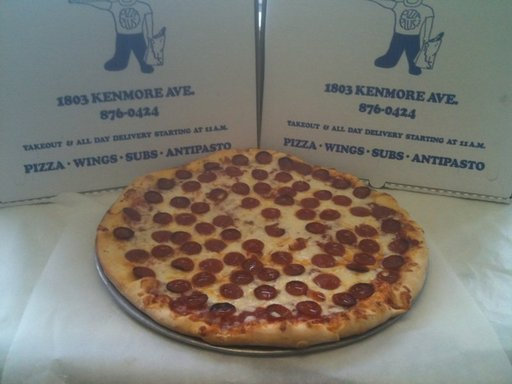

In [7]:
import random
from PIL import Image

random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path} | Image class: {image_class} | Image height: {img.height} | Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

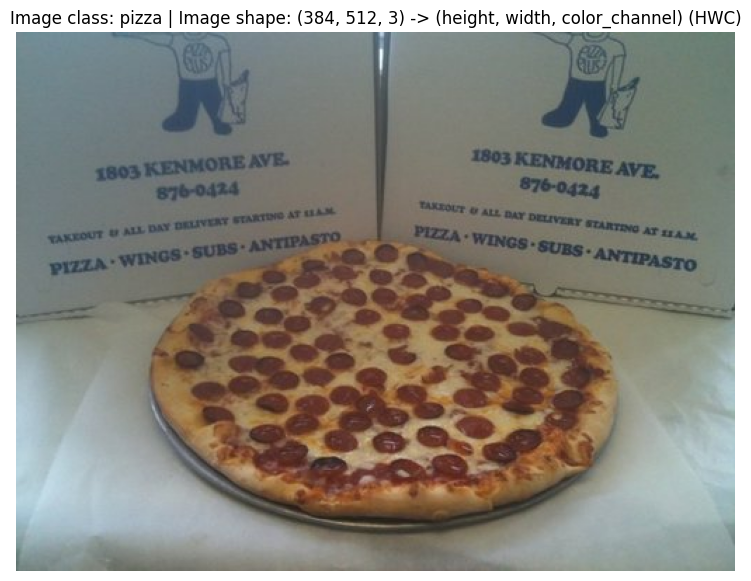

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array
img_as_array = np.asanyarray(img)

# Plot it
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> (height, width, color_channel) (HWC)")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Datasets` and subsenquently a `torch.utils.data.DataLoader`

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transform`

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

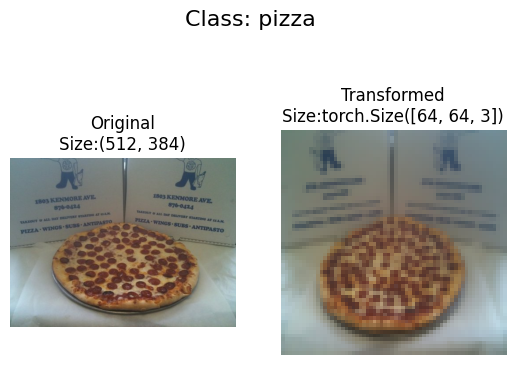

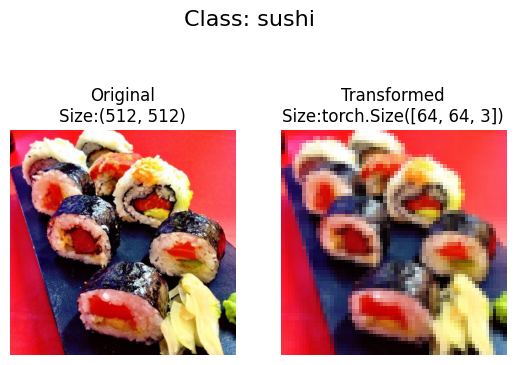

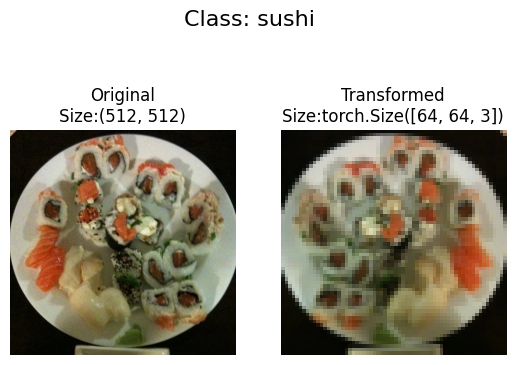

In [12]:
def plot_tranformed_images(image_paths, transform, n=3, seed=None):
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize:{transformed_image.size()}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_tranformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

## 4. Option 1: Loading image data using ImageFolder

In [13]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [17]:
# Index on the tran_data dataset
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor :\n {img}")
print(f"Image shape : {img.shape}")
print(f"Image dtype : {img.dtype}")
print(f"Image label : {label}")
print(f"Image label dtype : {type(label)}")

Image tensor :
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

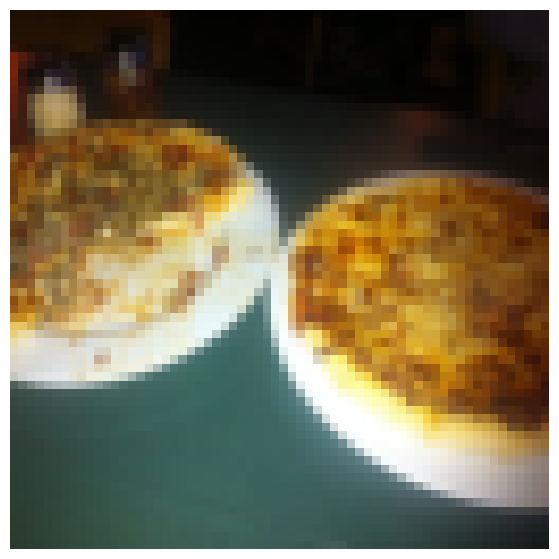

In [18]:
# Rearrange the order of dimensions
img_premute = img.permute(1, 2, 0)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_premute)
plt.axis(False)

## 4.1 Turn loaded images into `DataLoader`

In [23]:
# turn train and test datasets into Dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e10c0b5afd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e10c0b58710>)

In [24]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [25]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape} | Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) | Label Shape: torch.Size([1])


## 5. Option 2: Loading image data with custom dataset

1. Be able to load images from file
2. Be able to get names from the Dataset
3. Be able to get labels as dictionary

Pros:
* Can create a Dataset out of almost anything
* Not limited to PyTorch pre-build functions

Cons:
* It will not always work with "anything", maybe u will have to make changes
* Using a custom Dataset leads to more code, witch leads to more errors

In [28]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [29]:
train_data.classes, train_data.class_to_idx # Using torchvision.datasets.ImageFolder

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})